In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 393.8 kB/s eta 0:05:18
   ---------------------------------------- 0.2/124.9 MB 1.4 MB/s eta 0:01:30
   ---------------------------------------- 0.5/124.9 MB 2.8 MB/s eta 0:00:45
   ---------------------------------------- 1.5/124.9 MB 6.4 MB/s eta 0:00:20
    --------------------------------------- 2.3/124.9 MB 8.5 MB/s eta 0:00:15
   - -------------------------------------- 3.7/124.9 MB 11.3 MB/s eta 0:00:11
   - -------------------------------------- 4.8/124.9 MB 12.8 MB/s eta 0:00:10
   - -------------------------------------- 5.9/124.9 MB 13.9 MB/s eta 0:00:09
   -- ------------------------------------- 7.0/124.9 MB 14.9 MB/s eta 0:00:08
   -- ------------------------------------- 8.1/124.9 MB 15.6 MB/s eta 0:00:08


In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

In [12]:
#Read dataset
df = pd.read_csv('./20180221/02-21-2018.csv') 


In [13]:
df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,6,21/02/2018 08:33:25,37953,5,3,135,127,135,0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,500,17,21/02/2018 08:33:06,117573474,3,0,1500,0,500,500,...,8,0.0,0.0,0,0,58800000.0,23800000.0,75600000,42000000,Benign
2,500,17,21/02/2018 08:33:06,117573474,3,0,1500,0,500,500,...,8,0.0,0.0,0,0,58800000.0,23800000.0,75600000,42000000,Benign
3,500,17,21/02/2018 08:33:11,99743998,5,0,2500,0,500,500,...,8,4000290.0,0.0,4000290,4000290,31900000.0,37900000.0,75600000,7200397,Benign
4,500,17,21/02/2018 08:33:11,99743999,5,0,2500,0,500,500,...,8,4000286.0,0.0,4000286,4000286,31900000.0,37900000.0,75600000,7200399,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,55484,6,21/02/2018 02:33:29,1252,5,2,935,274,935,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1048571,57624,6,21/02/2018 02:33:29,19055,5,2,935,341,935,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1048572,57623,6,21/02/2018 02:33:29,36677,5,2,935,341,935,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1048573,57625,6,21/02/2018 02:33:29,1849,5,2,935,341,935,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


In [14]:
df.Label.value_counts()

Label
DDOS attack-HOIC        686012
Benign                  360833
DDOS attack-LOIC-UDP      1730
Name: count, dtype: int64

In [15]:
df.dtypes

Dst Port           int64
Protocol           int64
Timestamp         object
Flow Duration      int64
Tot Fwd Pkts       int64
                  ...   
Idle Mean        float64
Idle Std         float64
Idle Max           int64
Idle Min           int64
Label             object
Length: 80, dtype: object

### Preprocessing (normalization and padding values)

In [16]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

In [17]:
df = df.drop(columns=['Timestamp'])

In [18]:
features

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Siz

### Data sampling
Due to the space limit of GitHub files and the large size of network traffic data, we sample a small-sized subset for model learning using **k-means cluster sampling**

In [19]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [20]:
df.Label.value_counts()

Label
1    686012
0    360833
2      1730
Name: count, dtype: int64

In [21]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['Label']==2)]
df_major = df.drop(df_minor.index)

In [22]:
X = df_major.drop(['Label'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [23]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=100, random_state=0).fit(X)

In [24]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [25]:
df_major['klabel'].value_counts()

klabel
56    67649
5     59811
17    31341
22    29151
35    28876
      ...  
50     2504
65     2000
75     1956
48     1368
68      282
Name: count, Length: 100, dtype: int64

In [26]:
cols = list(df_major)
cols.insert(80, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

In [27]:
df_major

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
0,-0.717367,-0.058424,-0.054460,-0.039152,1.144111,-0.041009,-0.373413,-0.548133,-0.028397,-0.620028,...,-0.036990,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.040270,-0.027711,56,0
1,-0.701922,16.875469,17.672471,-0.039561,-0.886451,-0.032302,-0.763240,0.315371,55.662641,4.937395,...,-0.036990,-0.025032,-0.035523,-0.034716,69.796707,54.798887,53.154903,71.223606,65,0
2,-0.701922,16.875469,17.672471,-0.039561,-0.886451,-0.032302,-0.763240,0.315371,55.662641,4.937395,...,-0.036990,-0.025032,-0.035523,-0.034716,69.796707,54.798887,53.154903,71.223606,65,0
3,-0.701922,16.875469,14.983395,-0.039152,-0.886451,-0.025922,-0.763240,0.315371,55.662641,4.937395,...,19.635445,-0.025032,14.123597,25.464509,37.848837,87.285649,53.154903,12.187474,65,0
4,-0.701922,16.875469,14.983395,-0.039152,-0.886451,-0.025922,-0.763240,0.315371,55.662641,4.937395,...,19.635425,-0.025032,14.123583,25.464483,37.848837,87.285649,53.154903,12.187477,65,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,1.320040,-0.058424,-0.059995,-0.039152,0.467257,-0.035906,0.077804,1.344480,-0.028397,1.259861,...,-0.036990,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.040270,-0.027711,45,0
1048571,1.398736,-0.058424,-0.057310,-0.039152,0.467257,-0.035906,0.283460,1.344480,-0.028397,1.259861,...,-0.036990,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.040270,-0.027711,88,0
1048572,1.398699,-0.058424,-0.054652,-0.039152,0.467257,-0.035906,0.283460,1.344480,-0.028397,1.259861,...,-0.036990,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.040270,-0.027711,19,0
1048573,1.398773,-0.058424,-0.059905,-0.039152,0.467257,-0.035906,0.283460,1.344480,-0.028397,1.259861,...,-0.036990,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.040270,-0.027711,2,0


In [28]:
def typicalSampling(group):
    name = group.name
    frac = 0.8
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [29]:
result['Label'].value_counts()

Label
1    548806
0    288675
Name: count, dtype: int64

In [30]:
result

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
87038,-0.717367,-0.058424,-0.058985,-0.039765,-0.886451,-0.041870,-0.763240,-0.867512,-0.028397,-0.937259,...,-0.03699,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.04027,-0.027711,0,1
461401,-0.717367,-0.058424,-0.058989,-0.039765,-0.886451,-0.041870,-0.763240,-0.867512,-0.028397,-0.937259,...,-0.03699,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.04027,-0.027711,0,1
192442,-0.717367,-0.058424,-0.058997,-0.039765,-0.886451,-0.041870,-0.763240,-0.867512,-0.028397,-0.937259,...,-0.03699,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.04027,-0.027711,0,1
30929,-0.717367,-0.058424,-0.059053,-0.039765,-0.886451,-0.041870,-0.763240,-0.867512,-0.028397,-0.937259,...,-0.03699,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.04027,-0.027711,0,1
482257,-0.717367,-0.058424,-0.058966,-0.039765,-0.886451,-0.041870,-0.763240,-0.867512,-0.028397,-0.937259,...,-0.03699,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.04027,-0.027711,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8469,-0.717367,-0.058424,-0.056575,-0.039561,1.820966,-0.039689,2.106744,-0.058420,-0.028397,0.402162,...,-0.03699,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.04027,-0.027711,99,1
309655,-0.717367,-0.058424,-0.057533,-0.039561,1.820966,-0.039746,2.106744,-0.079712,-0.028397,0.366914,...,-0.03699,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.04027,-0.027711,99,1
49091,-0.717367,-0.058424,-0.055845,-0.039561,1.820966,-0.039746,2.106744,-0.079712,-0.028397,0.366914,...,-0.03699,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.04027,-0.027711,99,1
31822,-0.717367,-0.058424,-0.055895,-0.039561,1.820966,-0.039791,2.106744,-0.096272,-0.028397,0.339499,...,-0.03699,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.04027,-0.027711,99,1


In [31]:
result = result.drop(['klabel'],axis=1)
result = pd.concat([result, df_minor], ignore_index=True)

In [32]:
result.to_csv('./20180221/02-21-2018_km.csv',index=0)

### split train set and test set

In [33]:
# Read the sampled dataset
df=pd.read_csv('./20180221/02-21-2018_km.csv')

In [34]:
df

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,-0.717367,-0.058424,-0.058985,-0.039765,-0.886451,-0.041870,-0.76324,-0.867512,-0.028397,-0.937259,...,0.055542,-0.03699,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.04027,-0.027711,1
1,-0.717367,-0.058424,-0.058989,-0.039765,-0.886451,-0.041870,-0.76324,-0.867512,-0.028397,-0.937259,...,0.055542,-0.03699,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.04027,-0.027711,1
2,-0.717367,-0.058424,-0.058997,-0.039765,-0.886451,-0.041870,-0.76324,-0.867512,-0.028397,-0.937259,...,0.055542,-0.03699,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.04027,-0.027711,1
3,-0.717367,-0.058424,-0.059053,-0.039765,-0.886451,-0.041870,-0.76324,-0.867512,-0.028397,-0.937259,...,0.055542,-0.03699,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.04027,-0.027711,1
4,-0.717367,-0.058424,-0.058966,-0.039765,-0.886451,-0.041870,-0.76324,-0.867512,-0.028397,-0.937259,...,0.055542,-0.03699,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.04027,-0.027711,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839206,-0.717367,16.875469,13.752482,50.525786,-0.886451,50.527292,-0.76324,-0.791807,3.535830,-0.561281,...,-16.170177,-0.03699,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.04027,-0.027711,2
839207,-0.717367,16.875469,12.256009,19.035987,-0.886451,19.035498,-0.76324,-0.791807,3.535830,-0.561281,...,-16.170177,-0.03699,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.04027,-0.027711,2
839208,-0.717367,16.875469,13.945987,23.624839,-0.886451,23.624641,-0.76324,-0.791807,3.535830,-0.561281,...,-16.170177,-0.03699,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.04027,-0.027711,2
839209,-0.717367,16.875469,11.613341,13.916624,-0.886451,13.915810,-0.76324,-0.791807,3.535830,-0.561281,...,-16.170177,-0.03699,-0.025032,-0.035523,-0.034716,-0.037298,-0.036925,-0.04027,-0.027711,2


In [35]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [36]:
unique, counts = np.unique(y, return_counts=True)
print("Phân bố lớp:", dict(zip(unique, counts)))

Phân bố lớp: {0: 288675, 1: 548806, 2: 1730}


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [38]:
X.shape


(839211, 78)

## Feature engineering

### Feature selection by information gain

In [39]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [40]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [41]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [42]:
X_fs = df[fs].values

In [43]:
X_fs.shape

(839211, 41)

In [44]:
y.shape

(839211,)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [45]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [46]:
X_fss = fcbf.fit_transform(X_fs,y)

In [47]:
X_fss.shape

(839211, 20)

### Re-split train & test sets after feature selection

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [49]:
X_train.shape

(671368, 20)

In [50]:
pd.Series(y_train).value_counts()

1    439044
0    230940
2      1384
Name: count, dtype: int64

### SMOTE to solve class-imbalance

In [51]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:10000})

In [52]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [53]:
pd.Series(y_train).value_counts()

1    439044
0    230940
2     10000
Name: count, dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

Accuracy of XGBoost: 0.9999940420512026
Precision of XGBoost: 0.9999940592210839
Recall of XGBoost: 0.9999940420512026
F1-score of XGBoost: 0.999994046324068
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57735
           1       1.00      1.00      1.00    109762
           2       1.00      1.00      1.00       346

    accuracy                           1.00    167843
   macro avg       1.00      1.00      1.00    167843
weighted avg       1.00      1.00      1.00    167843



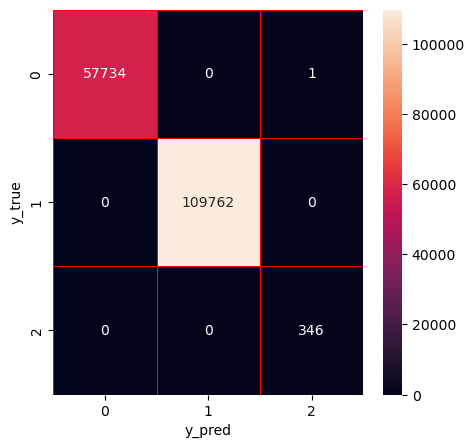

In [54]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [56]:
!pip install hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
Using cached future-1.0.0-py3-none-any.whl (491 kB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)


In [57]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [03:57<00:00, 11.89s/trial, best loss: -1.0]
XGBoost: Hyperopt estimated optimum {'learning_rate': -1.1450449167331331, 'max_depth': 50.0, 'n_estimators': 45.0}


Accuracy of XGBoost: 1.0
Precision of XGBoost: 1.0
Recall of XGBoost: 1.0
F1-score of XGBoost: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57735
           1       1.00      1.00      1.00    109762
           2       1.00      1.00      1.00       346

    accuracy                           1.00    167843
   macro avg       1.00      1.00      1.00    167843
weighted avg       1.00      1.00      1.00    167843



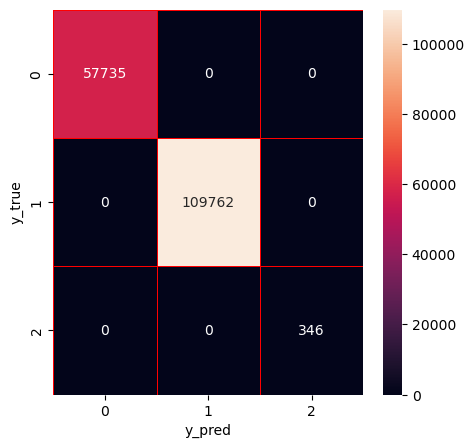

In [58]:
xg = xgb.XGBClassifier(learning_rate= 1.1450449167331331, n_estimators = 45, max_depth = 50)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [59]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 1.0
Precision of RF: 1.0
Recall of RF: 1.0
F1-score of RF: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57735
           1       1.00      1.00      1.00    109762
           2       1.00      1.00      1.00       346

    accuracy                           1.00    167843
   macro avg       1.00      1.00      1.00    167843
weighted avg       1.00      1.00      1.00    167843



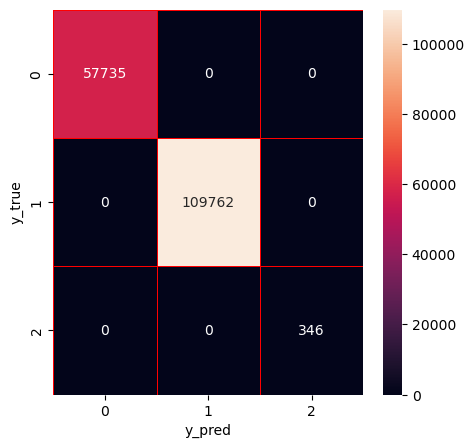

In [60]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [61]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [37:34<00:00, 112.72s/trial, best loss: -1.0]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 24.0, 'max_features': 7.0, 'min_samples_leaf': 7.0, 'min_samples_split': 4.0, 'n_estimators': 24.0}


Accuracy of RF: 1.0
Precision of RF: 1.0
Recall of RF: 1.0
F1-score of RF: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57735
           1       1.00      1.00      1.00    109762
           2       1.00      1.00      1.00       346

    accuracy                           1.00    167843
   macro avg       1.00      1.00      1.00    167843
weighted avg       1.00      1.00      1.00    167843



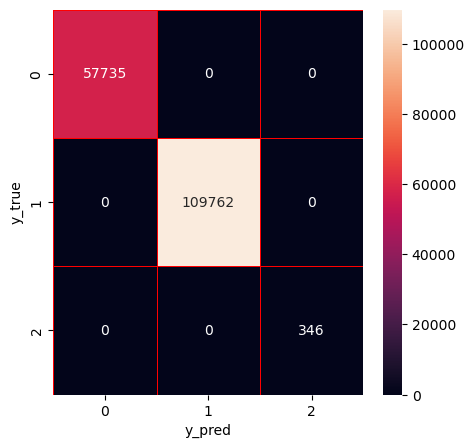

In [62]:
rf_hpo = RandomForestClassifier(n_estimators = 24, min_samples_leaf = 7, max_depth = 24, min_samples_split = 4, max_features = 7, criterion = 'gini')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [63]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Apply DT

Accuracy of DT: 0.9999940420512026
Precision of DT: 0.9999940592210839
Recall of DT: 0.9999940420512026
F1-score of DT: 0.999994046324068
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57735
           1       1.00      1.00      1.00    109762
           2       1.00      1.00      1.00       346

    accuracy                           1.00    167843
   macro avg       1.00      1.00      1.00    167843
weighted avg       1.00      1.00      1.00    167843



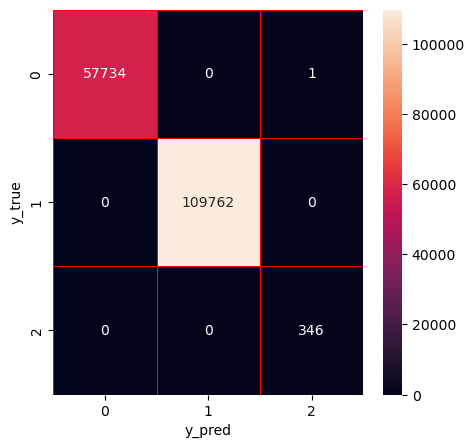

In [64]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [65]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|██████████| 50/50 [01:25<00:00,  1.72s/trial, best loss: -1.0]
Decision tree: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 36.0, 'max_features': 17.0, 'min_samples_leaf': 2.0, 'min_samples_split': 9.0}


Accuracy of DT: 0.9999940420512026
Precision of DT: 0.9999940592210839
Recall of DT: 0.9999940420512026
F1-score of DT: 0.999994046324068
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57735
           1       1.00      1.00      1.00    109762
           2       1.00      1.00      1.00       346

    accuracy                           1.00    167843
   macro avg       1.00      1.00      1.00    167843
weighted avg       1.00      1.00      1.00    167843



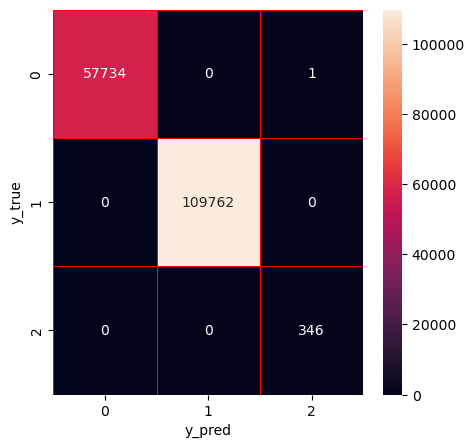

In [66]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 2, max_depth = 36, min_samples_split = 9, max_features = 17, criterion = 'entropy')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [67]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### Apply ET

Accuracy of ET: 1.0
Precision of ET: 1.0
Recall of ET: 1.0
F1-score of ET: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57735
           1       1.00      1.00      1.00    109762
           2       1.00      1.00      1.00       346

    accuracy                           1.00    167843
   macro avg       1.00      1.00      1.00    167843
weighted avg       1.00      1.00      1.00    167843



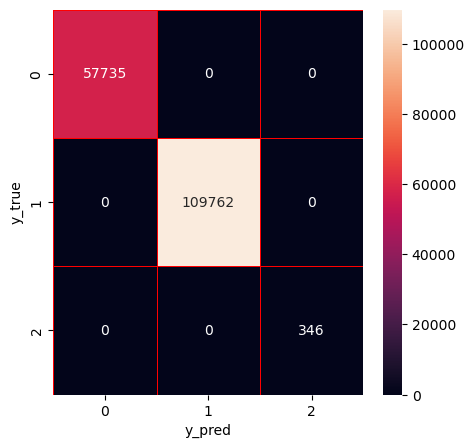

In [68]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [69]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [22:03<00:00, 66.17s/trial, best loss: -1.0] 
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 15.0, 'max_features': 9.0, 'min_samples_leaf': 8.0, 'min_samples_split': 10.0, 'n_estimators': 124.0}


Accuracy of ET: 1.0
Precision of ET: 1.0
Recall of ET: 1.0
F1-score of ET: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57735
           1       1.00      1.00      1.00    109762
           2       1.00      1.00      1.00       346

    accuracy                           1.00    167843
   macro avg       1.00      1.00      1.00    167843
weighted avg       1.00      1.00      1.00    167843



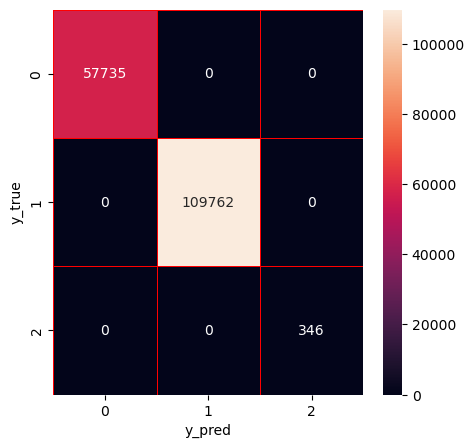

In [70]:
et_hpo = ExtraTreesClassifier(n_estimators = 124, min_samples_leaf = 8, max_depth = 15, min_samples_split = 10, max_features = 9, criterion = 'gini')
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [71]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [72]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1


In [73]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [74]:
dt_train.shape

(679984, 1)

In [75]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 1.0
Precision of Stacking: 1.0
Recall of Stacking: 1.0
F1-score of Stacking: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57735
           1       1.00      1.00      1.00    109762
           2       1.00      1.00      1.00       346

    accuracy                           1.00    167843
   macro avg       1.00      1.00      1.00    167843
weighted avg       1.00      1.00      1.00    167843



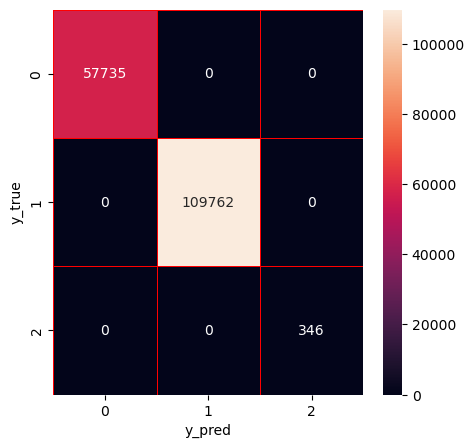

In [76]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [77]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [02:49<00:00,  8.47s/trial, best loss: -1.0]
XGBoost: Hyperopt estimated optimum {'learning_rate': -0.8951266731566636, 'max_depth': 19.0, 'n_estimators': 50.0}


Accuracy of XGBoost: 1.0
Precision of XGBoost: 1.0
Recall of XGBoost: 1.0
F1-score of XGBoost: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57735
           1       1.00      1.00      1.00    109762
           2       1.00      1.00      1.00       346

    accuracy                           1.00    167843
   macro avg       1.00      1.00      1.00    167843
weighted avg       1.00      1.00      1.00    167843



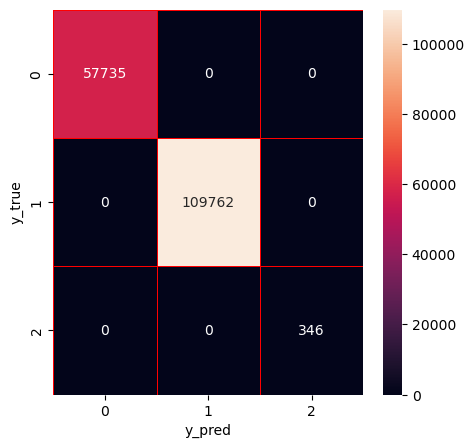

In [78]:
xg = xgb.XGBClassifier(learning_rate= 0.8951266731566636, n_estimators = 50, max_depth = 19)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Anomaly-based IDS

### Generate the BOT datasets for unknown attack detection

In [79]:
df=pd.read_csv('./20180221/02-21-2018_km.csv')

In [80]:
df.Label.value_counts()

Label
1    548806
0    288675
2      1730
Name: count, dtype: int64

In [81]:
df1 = df[df['Label'] != 2]
df1['Label'][df1['Label'] > 0] = 1
df1.to_csv('./20180221/02-21-2018_km_without_LOIC.csv',index=0)

In [82]:
df2 = df[df['Label'] == 2]
df2['Label'][df2['Label'] == 2] = 1
df2.to_csv('./20180221/02-21-2018_km_LOIC.csv',index=0)

### Read the generated datasets for unknown attack detection

In [103]:
df1 = pd.read_csv('./20180221/02-21-2018_km_without_LOIC.csv')

In [104]:
df2 = pd.read_csv('./20180221/02-21-2018_km_LOIC.csv')

In [105]:
features = df1.drop(['Label'],axis=1).dtypes[df1.dtypes != 'object'].index
df1[features] = df1[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df2[features] = df2[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df1 = df1.fillna(0)
df2 = df2.fillna(0)

In [106]:
df1.Label.value_counts()

Label
1    548806
0    288675
Name: count, dtype: int64

In [107]:
df2.Label.value_counts()

Label
1    1730
Name: count, dtype: int64

In [108]:
df2p=df1[df1['Label']==0]
df2pp=df2p.sample(n=None, frac=1730/288675, replace=False, weights=None, random_state=None, axis=0)
df2=pd.concat([df2, df2pp])

In [109]:
df2.Label.value_counts()

Label
1    1730
0    1730
Name: count, dtype: int64

In [110]:
df = pd.concat([df1, df2], ignore_index=True)

In [111]:
df.shape

(840941, 79)

In [112]:
X = df.drop(['Label'],axis=1) .values
y = df.iloc[:, -1].values.reshape(-1,1)
y.shape


(840941, 1)

In [113]:
y=np.ravel(y)
y.shape

(840941,)

In [114]:
pd.Series(y).value_counts()

1    550536
0    290405
Name: count, dtype: int64

In [115]:
y.shape

(840941,)

### Feature engineering (IG, FCBF, and KPCA)

#### Feature selection by information gain (IG)

In [116]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

In [117]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [118]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [119]:
X_fs = df[fs].values

In [120]:
X_fs.shape

(840941, 41)

In [121]:
y.shape

(840941,)

In [122]:
X_fs

array([[-0.84367504, -0.84367504, -0.8665935 , ..., -0.99541684,
        -0.99599714, -0.01078387],
       [-0.84367504, -0.84367504, -0.8665935 , ..., -0.99541684,
        -0.99599714, -0.01083586],
       [-0.84367504, -0.84367504, -0.8665935 , ..., -0.99541684,
        -0.99599714, -0.01093982],
       ...,
       [ 1.26207455,  1.26207455,  1.33177599, ...,  1.04958841,
         1.05032626, -0.02666698],
       [ 1.26207455,  1.26207455,  1.33177599, ...,  1.01091219,
         1.01162511, -0.02667098],
       [ 1.26207455,  1.26207455,  1.33177599, ...,  0.97384747,
         0.97453651, -0.02666698]])

#### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [123]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [124]:
X_fss = fcbf.fit_transform(X_fs,y)

In [125]:
X_fss.shape

(840941, 20)

In [126]:
X_fss

array([[-0.84812934, -0.88657002, -0.88657002, ..., -0.99832077,
        -0.997825  , -0.71827084],
       [-0.84812934, -0.88657002, -0.88657002, ..., -0.99832077,
        -0.997825  , -0.71827084],
       [-0.84812934, -0.88657002, -0.88657002, ..., -0.99832077,
        -0.997825  , -0.71827084],
       ...,
       [ 0.35822961,  0.46500593,  0.46500593, ...,  1.00168085,
         1.00217854,  1.29807679],
       [ 0.35822961,  0.46500593,  0.46500593, ...,  1.00168085,
         1.00217854,  1.46770773],
       [ 0.35822961,  0.46500593,  0.46500593, ...,  1.00168085,
         1.00217854,  1.16259258]])

####  kernel principal component analysis (KPCA)

In [127]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 10, kernel = 'rbf')
kpca.fit(X_fss, y)
X_kpca = kpca.transform(X_fss)

# from sklearn.decomposition import PCA
# kpca = PCA(n_components = 10)
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

MemoryError: Unable to allocate 5.15 TiB for an array with shape (840941, 840941) and data type float64

### Train-test split after feature selection

In [ ]:
X_train = X_kpca[:len(df1)]
y_train = y[:len(df1)]
X_test = X_kpca[len(df1):]
y_test = y[len(df1):]

### Solve class-imbalance by SMOTE

In [ ]:
pd.Series(y_train).value_counts()

0    3919
1    3868
Name: count, dtype: int64

In [99]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={1:3919})
X_train, y_train = smote.fit_resample(X_train, y_train)

In [100]:
pd.Series(y_train).value_counts()

0    3919
1    3919
Name: count, dtype: int64

In [101]:
pd.Series(y_test).value_counts()

1    226
0    226
Name: count, dtype: int64

### Apply the cluster labeling (CL) k-means method

In [102]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics

In [103]:
def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y_test,result2)
    print(str(acc))
    print(cm)

In [104]:
CL_kmeans(X_train, X_test, y_train, y_test, 8)

              precision    recall  f1-score   support

           0       1.00      0.79      0.88       226
           1       0.82      1.00      0.90       226

    accuracy                           0.89       452
   macro avg       0.91      0.89      0.89       452
weighted avg       0.91      0.89      0.89       452

0.8938053097345132
[[178  48]
 [  0 226]]


### Hyperparameter optimization of CL-k-means
Tune "k"

In [106]:
#Hyperparameter optimization by BO-GP
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn import metrics

space  = [Integer(2, 50, name='n_clusters')]
@use_named_args(space)
def objective(**params):
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    cm=metrics.accuracy_score(y_test,result2)
    print(str(n)+" "+str(cm))
    return (1-cm)
from skopt import gp_minimize
import time
t1=time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
t2=time.time()
print(t2-t1)
print("Best score=%.4f" % (1-res_gp.fun))
print("""Best parameters: n_clusters=%d""" % (res_gp.x[0]))

30 0.7057522123893806
43 0.6946902654867256
43 0.7101769911504425
43 0.7013274336283186
32 0.7146017699115044
20 0.6969026548672567
16 0.6504424778761062
5 0.5730088495575221
15 0.7212389380530974
25 0.4778761061946903
31 0.7079646017699115
13 0.8473451327433629
12 0.7057522123893806
50 0.4823008849557522
14 0.668141592920354
33 0.7123893805309734
38 0.4690265486725664
44 0.48451327433628316
42 0.7057522123893806
34 0.6969026548672567
30.04314661026001
Best score=0.8473
Best parameters: n_clusters=13


In [107]:
#Hyperparameter optimization by BO-TPE
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

def objective(params):
    params = {
        'n_clusters': int(params['n_clusters']), 
    }
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    score=metrics.accuracy_score(y_test,result2)
    print(str(params['n_clusters'])+" "+str(score))
    return {'loss':1-score, 'status': STATUS_OK }
space = {
    'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

11 0.668141592920354                                  
4 0.5730088495575221                                                           
37 0.4579646017699115                                                          
22 0.6969026548672567                                                          
36 0.7079646017699115                                                            
22 0.7079646017699115                                                            
25 0.4778761061946903                                                           
36 0.7079646017699115                                                           
43 0.9336283185840708                                                           
32 0.9070796460176991                                                           
38 0.6792035398230089                                                            
28 0.7079646017699115                                                            
5 0.668141592920354                                  

In [108]:
CL_kmeans(X_train, X_test, y_train, y_test, 13)

              precision    recall  f1-score   support

           0       1.00      0.70      0.83       226
           1       0.77      1.00      0.87       226

    accuracy                           0.85       452
   macro avg       0.89      0.85      0.85       452
weighted avg       0.89      0.85      0.85       452

0.8517699115044248
[[159  67]
 [  0 226]]


### Apply the CL-k-means model with biased classifiers

In [109]:
# Only a sample code to show the logic. It needs to work on the entire dataset to generate sufficient training samples for biased classifiers
def Anomaly_IDS(X_train, X_test, y_train, y_test,n,b=100):
    # CL-kmeans
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y2,result2)
    print(str(acc))
    print(cm)
    
    #Biased classifier construction
    count=0
    print(len(y))
    a=np.zeros(n)
    b=np.zeros(n)
    FNL=[]
    FPL=[]
    for v in range(0,n):
        al=[]
        bl=[]
        for i in range(0,len(y)):   
            if result[i]==v:        
                if y[i]==1:        #label 1
                    a[v]=a[v]+1
                    al.append(i)
                else:             #label 0
                    b[v]=b[v]+1
                    bl.append(i)
        if a[v]<=b[v]:
            FNL.extend(al)
        else:
            FPL.extend(bl)
        #print(str(v)+"="+str(a[v]/(a[v]+b[v])))
        
    dffp=df.iloc[FPL, :]
    dffn=df.iloc[FNL, :]
    dfva0=df[df['Label']==0]
    dfva1=df[df['Label']==1]
    
    dffpp=dfva1.sample(n=None, frac=len(FPL)/dfva1.shape[0], replace=False, weights=None, random_state=None, axis=0)
    dffnp=dfva0.sample(n=None, frac=len(FNL)/dfva0.shape[0], replace=False, weights=None, random_state=None, axis=0)
    
    dffp_f=pd.concat([dffp, dffpp])
    dffn_f=pd.concat([dffn, dffnp])
    
    Xp = dffp_f.drop(['Label'],axis=1)  
    yp = dffp_f.iloc[:, -1].values.reshape(-1,1)
    yp=np.ravel(yp)

    Xn = dffn_f.drop(['Label'],axis=1)  
    yn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    yn=np.ravel(yn)
    
    rfp = RandomForestClassifier(random_state = 0)
    rfp.fit(Xp,yp)
    rfn = RandomForestClassifier(random_state = 0)
    rfn.fit(Xn,yn)

    dffnn_f=pd.concat([dffn, dffnp])
    
    Xnn = dffn_f.drop(['Label'],axis=1)  
    ynn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    ynn=np.ravel(ynn)

    rfnn = RandomForestClassifier(random_state = 0)
    rfnn.fit(Xnn,ynn)

    X2p = df2.drop(['Label'],axis=1) 
    y2p = df2.iloc[:, -1].values.reshape(-1,1)
    y2p=np.ravel(y2p)

    result2 = km_cluster.predict(X2p)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y)):
            if result[i]==v:
                if y[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    l1=[]
    l0=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y2p)):
        if result2[v] in list1:
            result2[v]=0
            l0.append(v)
        elif result2[v] in list2:
            result2[v]=1
            l1.append(v)
        else:
            print("-1")
    print(classification_report(y2p, result2))
    cm=confusion_matrix(y2p,result2)
    print(cm)